---
layout: post
title: Hotel Review Analysis Using NLP Part 1
---

## Background
Customer reviews are vital in understanding how a company can focus its attention on maintaining and growing its customer base. This is especially important in the hospitality industry where customers’ brand loyalty relies on consistent, positive experiences for frequent travelers. Text data is time consuming to process and it can be difficult to get an understanding of subtle trends in the data without cross checking reviews to see if keywords are predictive of an overall rating. To aid this effort I am going to analyze customer feedback from an internationally operating hotel company. My goal is to build a model that can predict an overall positive or negative rating, based on common keywords in reviews. Once a reliable model has been developed I can deliver the keywords to company management responsible for improving customer experience. These insights will inform them as to what the hotels are doing well and where they can improve.

In this post I am going to explore and clean the dataset in preparation for modeling. I use `Pandas` and `Matplotlib` to explore the data and clean up issues. I also use `SKLearn.feature_extraction.CountVectorizer` to parse the text reviews and add sparse matrices to the core data. In the follow up post I will compare several machine learning models to predict a positive or negative customer review based on their feedback and extract the relevant keywords for positive and negative reviews.


The repository for this project can be found on my
[Github](www.github.com/russ-kibat/Hotel-Reviews). 

---

## Exploratory Data Analysis
To get started I need to import the standard data science libraries and read the data into memory.


In [3]:
## Import Libraries 
# Data wrangling 
import pandas as pd # dataframe manipulation 
import numpy as np # dependency  for pyplot
import matplotlib.pyplot as plt # create visualizations
from sklearn.model_selection import train_test_split # Data sampling

# Text parsing 
from sklearn.feature_extraction.text import CountVectorizer # process text data

# Read in data
raw_data = pd.read_csv('data/Hotel_Reviews.csv')

In [4]:
# Read in data
raw_data = pd.read_csv('data/Hotel_Reviews.csv')

### Data Dictionary

Each row is a hotel guest review of a stay along with some information about the hotel and the reviewer. The review is broken up with a positive and negative component and labeled with tags that apply to the hotel stay being reviewed. Each review is stored alongside metadata and aggregate metrics for both the hotel and reviewer. It appears each time a review is added multiple database records must be updated.



**Hotel data**
- Hotel_Address - Property address
- Average_Score - Composite score for the hotel
- Hotel_Name - Property address
- Total_Number_of_Reviews - Count of reviews per hotel
- lat - Latitude coordinate
- lng - Longitude coordinate



**Review specific data**
- Review_Date - Date of review
- Negative_Review - Text of negative portion of review
- Review_Total_Negative_Word_Counts - Number of words in negative review
- Positive_Review - Text of positive portion of review
- Review_Total_Positive_Word_Counts - Number of words in positive review
- Reviewer_Score - The single number score a reviewer gives the hotel
- Tags - List features that apply to the stay being reviewed

**Reviewer Data**
- Reviewer_Nationality - Country of origin of guest
- Total_Number_of_Reviews_Reviewer_Has_Given' - Number of reviews the guest has given
- Days_since_review - The time passed since the guests most recent review

**Other Data**
- Additional_Number_of_Scoring - Total number of reviews for a hotel

I want to take a peek into the data to get a feel for what it contains and the shape of the file. There are over half a million reviews and the columns do match the description in the data dictionary. It’s very helpful there are designated positive and negative reviews. It will be interesting to see words that appear on both sides. That may provide insight to things that can sway a guest’s experience rather than things that should be added or removed from the experiences.


In [5]:
# show the number of rows and columns in the data
print(f'The data constains {raw_data.shape[0]} rows and {raw_data.shape[1]} columns.')

# show a row of the data
# instead of df.head(), pick single row and transpose it for the reader
display(raw_data[2:3].T.style)

The data constains 515738 rows and 17 columns.


,2
Hotel_Address,s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands
Additional_Number_of_Scoring,194
Review_Date,7/31/2017
Average_Score,7.700000
Hotel_Name,Hotel Arena
Reviewer_Nationality,Australia
Negative_Review,Rooms are nice but for elderly a bit difficult as most rooms are two story with narrow steps So ask for single level Inside the rooms are very very basic just tea coffee and boiler and no bar empty fridge
Review_Total_Negative_Word_Counts,42
Total_Number_of_Reviews,1403
Positive_Review,Location was good and staff were ok It is cute hotel the breakfast range is nice Will go back


### Data Cleaning

In [6]:
# look at the value counts and datatypes
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

A couple things jump out when looking at this summary. First, I’m happy to see that most rows are complete. There are some missing coordinates for the location. Luckily, we have the hotel address so it will be possible to complete those rows. For now, I’m going to skip that and focus on fixing the data types. There are several that are stored as objects that would be useful for modeling if they were converted to numbers. `Review_Date` can be changed to a datetime type. Looking at my sample row above I can see that `days_since_review` can include “days”. I remove that string and change that column to an integer.


In [7]:
## convert the dates since last review to a datetime columns
raw_data['Review_Date'] = pd.to_datetime(raw_data['Review_Date'])

# remove separate the number and text in the `days_since_review`
# split the string at the first space and place the first value returned in its place as an int
raw_data['days_since_review'] = raw_data['days_since_review'].str.split(' ').str[0].astype('int')



## Feature Engineering

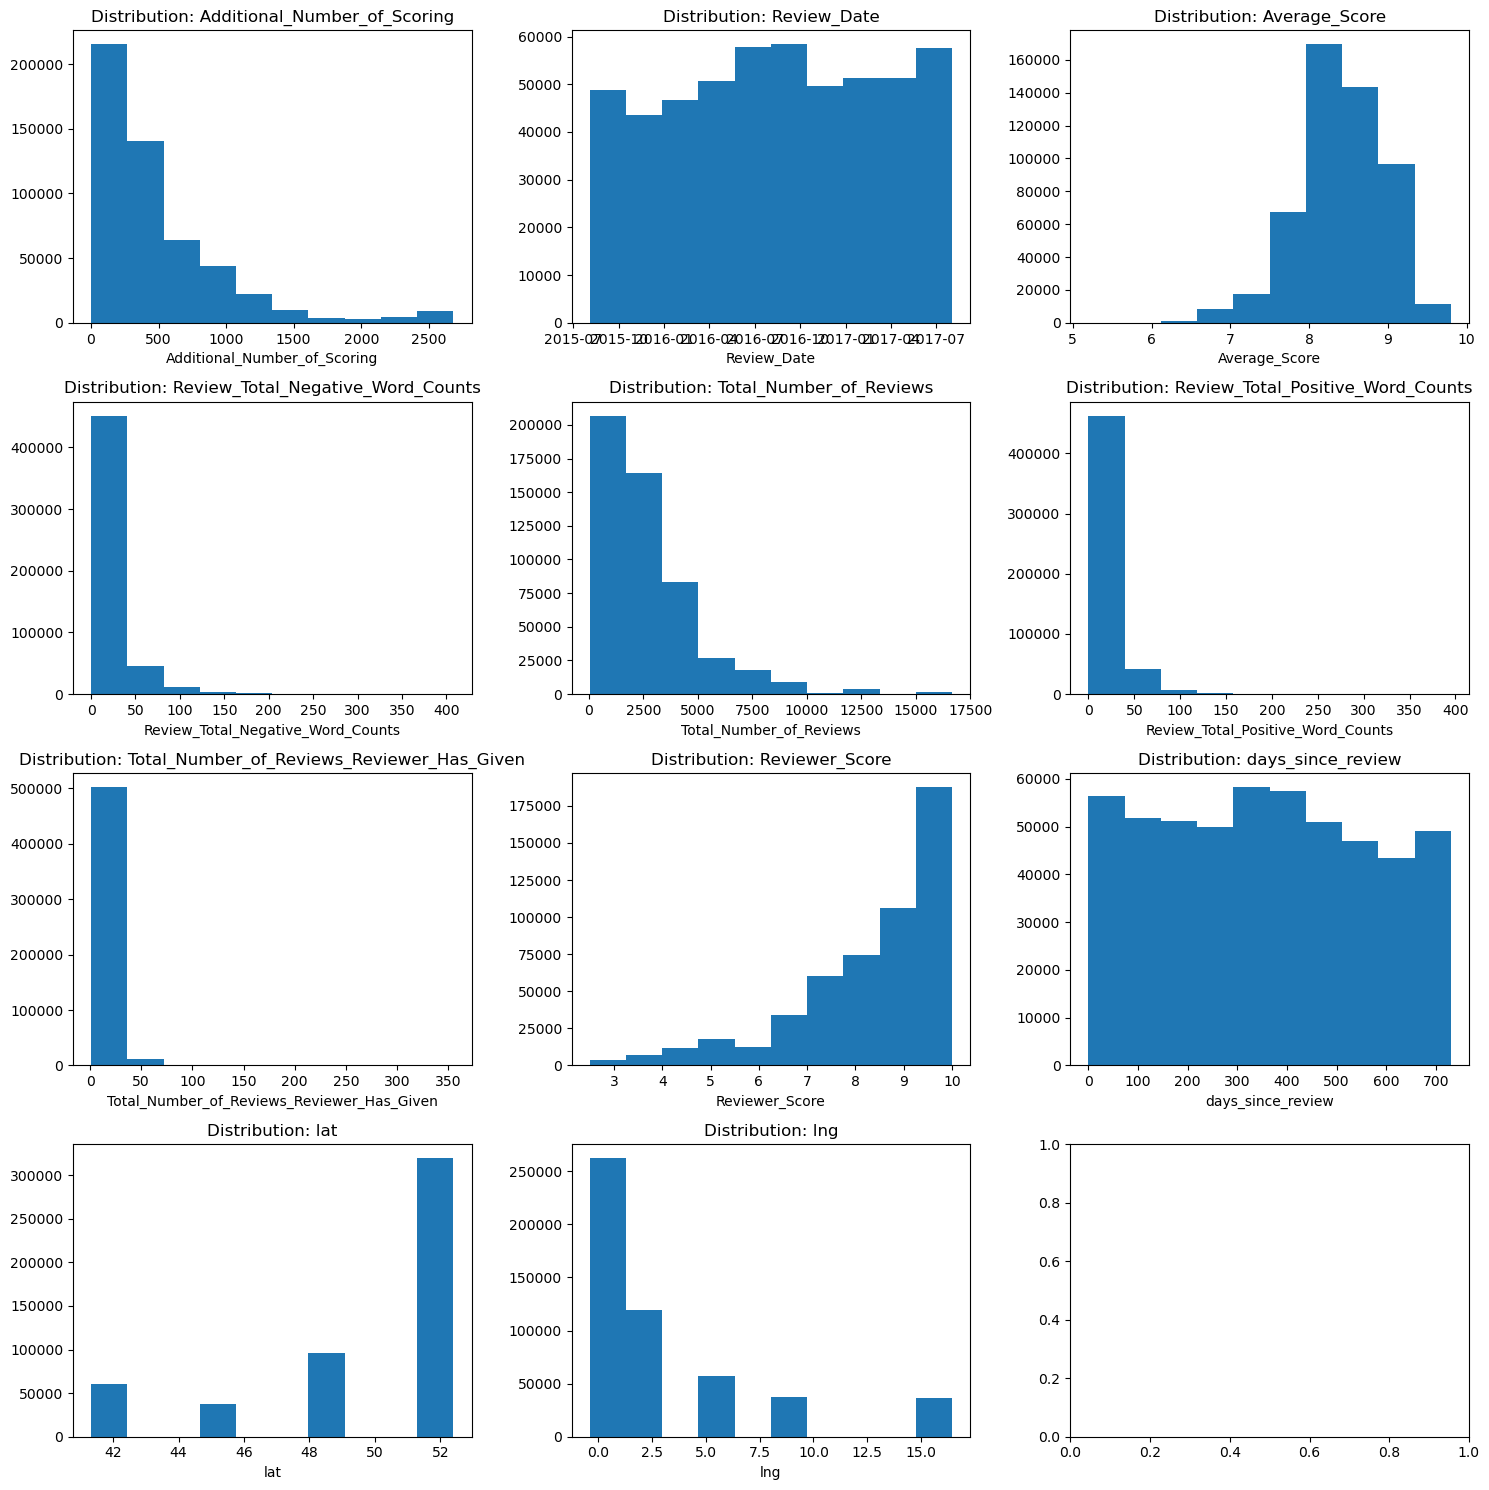

In [8]:
# Create histograms of numeric columns
i = 1
plt.subplots(4,3, figsize=(15,15))

# plot a histogram for each column in the data, excluding non-numerics
for col in raw_data.select_dtypes(exclude='object').columns:
    
    plt.subplot(4,3,i)
    plt.hist(raw_data[col], bins=10)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col)
    i +=1

plt.tight_layout()
plt.show()


With the data types fixed I can now look at the distributions of the numeric columns and see if there is anything that will be a problem in the dataset. The target of the model will be the `Reviewer_Score`. That column is heavily skewed to higher ratings and that imbalance will be a problem for the models. Since I am ultimately looking to predict a positive/negative outcome I can convert this to a binary if I count reviews 9.0 or more as positive and reviews less than 9 as negative. This conversion leaves me with a nearly 50/50 split of positive and negative reviews.

I ran into memory issues once I started working with the count vectorizer. To get around this I sampled 10% of the data and confirmed that the distribution of the target matched the original dataset.

I also take the chance to get rid of object columns the models will not be looking at. Of course, I leave the review columns to parse in the next section.


In [9]:
# replace ratings with a binary 
raw_data['Rating Int'] = np.where(raw_data['Reviewer_Score'] >= 9.0,1,0)

# check the value counts of the new binary score. 
print(f'{raw_data["Rating Int"].value_counts()[0]/raw_data["Rating Int"].value_counts().sum()*100}% negative reviews\n{raw_data["Rating Int"].value_counts()[1]/raw_data["Rating Int"].value_counts().sum()*100}% positive reviews')

52.10029123314551% negative reviews
47.89970876685449% positive reviews


In [10]:
# create a new dataframe that is a sample of the entire data set
smaller_df = raw_data.sample(frac=.1, random_state=40)

## reindex the new dataframe
smaller_df = smaller_df.reset_index(drop=True)

#check the shapes to confirm a success 
print(f'Original data shape{raw_data.shape}')
print(f'Sampled data shape {smaller_df.shape}')
print(f'The sample data frame has {round(smaller_df.shape[0]/raw_data.shape[0]*100,0)}% of the rows as the original df.')

# Confirm proportionate class representation between the original and new data frames
# Create a df to store the class mixes
validation_df = pd.DataFrame()

# calculate the class mixes and add them to the new df
validation_df['Raw mix'] = round(raw_data.value_counts('Rating Int', normalize=True)*100,0)
validation_df['sample mix'] = round(smaller_df.value_counts('Rating Int', normalize=True)*100,0)

# show the new df
display(validation_df.sort_values(by=['Rating Int']))
## drop other object columns
# get a list of object cols
object_cols_to_drop = list(smaller_df.select_dtypes(include='object').columns)

# remove the cols I want to keep
object_cols_to_drop.remove('Negative_Review')
object_cols_to_drop.remove('Positive_Review')

# drop the remaining object columns
clean_df= smaller_df.drop(object_cols_to_drop, axis=1)

# look at the remaining columns
print(clean_df.info())


Original data shape(515738, 18)
Sampled data shape (51574, 18)
The sample data frame has 10.0% of the rows as the original df.


,Raw mix,sample mix
Rating Int,,
0,52.0,52.0
1,48.0,48.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51574 entries, 0 to 51573
Data columns (total 14 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Additional_Number_of_Scoring                51574 non-null  int64         
 1   Review_Date                                 51574 non-null  datetime64[ns]
 2   Average_Score                               51574 non-null  float64       
 3   Negative_Review                             51574 non-null  object        
 4   Review_Total_Negative_Word_Counts           51574 non-null  int64         
 5   Total_Number_of_Reviews                     51574 non-null  int64         
 6   Positive_Review                             51574 non-null  object        
 7   Review_Total_Positive_Word_Counts           51574 non-null  int64         
 8   Total_Number_of_Reviews_Reviewer_Has_Given  51574 non-null  int64         
 9   Review

### Count Vectorization

In order to model the text reviews I need to represent them as numbers. I parse each word of each review and create sparse matrices of reviews in the review. SKLearn’s countvectorizer is the tool I use to accomplish this. Once the vectorizer is initialized and the object for the positive reviews is created it can be transformed into a sparse matrix. For each word in the reviews there is a column with the number of times it appears in the review. This is then turned into a Pandas friendly data frame and appended to the core data. At this point I save the datafile and am ready to model.

It’s important that I split my data into a test/train dataset before this process begins. In the process of the test reviews should not be included in training set vectorization to ensure the test reviews do not influence the model.


In [11]:
# Separate the target column from the data column

X = smaller_df.drop('Rating Int',axis=1)
y = smaller_df['Rating Int']

#set up the test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [12]:

# Create the bag of words for positive reviews
positive_bagofwords = CountVectorizer(min_df = 10, stop_words='english')
positive_bagofwords.fit(X_train['Positive_Review'])

# transform the bag of words to a sparse matrix
positive_bagofwords_transfromed = positive_bagofwords.transform(X_train['Positive_Review'])

# #Count the number of words the bag of words categorized
print(f' Positive review words identified {len(positive_bagofwords.get_feature_names_out())}')

# Create a user friendly df from the bag of words and tag them as positive
positive_sparse_df = pd.DataFrame(columns=positive_bagofwords.get_feature_names_out(), data=positive_bagofwords_transfromed.toarray()).add_prefix('p_',)



 Positive review words identified 2316


In [13]:
#create a sparse matrix for the negative reviews

negative_bagofwords = CountVectorizer(min_df = 10, stop_words='english')
negative_bagofwords.fit(X_train['Negative_Review'])

# transform the bag of words to a sparse matrix
negative_bagofwords_transfromed = negative_bagofwords.transform(X_train['Negative_Review'])

#Count the number of words the bag of words categorized
len(negative_bagofwords.get_feature_names_out())

# Create a user friendly df from the bag of words
negative_sparse_df = pd.DataFrame(columns=negative_bagofwords.get_feature_names_out(), data=negative_bagofwords_transfromed.toarray()).add_prefix('n_')


In [14]:
# combine the three dataframes
df = pd.concat([clean_df,positive_sparse_df, negative_sparse_df], axis=1)

# Look for duplicate columns
print(df.columns[df.columns.duplicated()])

# Show the final dataframe shape
print(f' Final dataframe shape: {df.shape}')


Index([], dtype='object')
 Final dataframe shape: (51574, 5304)


In [24]:
# Save the final dataframe to CSV
df.to_csv('data/clean_hotel_data_1.csv')

Working through this process has been a great chance to begin to understand what it takes to preprocess data for natural language processing. After the straightforward data cleaning, getting into parsing text data is a new area for me to explore. I would like to work on the sparse matrices to further remove some of the extraneous terms. My initial approach was to look for words that appear in at least 10 reviews and remove a basic set of stop words in English. My next steps would be adding stemming techniques and looking for ngrams to make the sparse matrices smaller and have more impactful terms.

There is still some unfinished business with the core of the data. Making use of the tags and hotel address information could be insightful for a more detailed modeling. There may be information about the length of stay, reason for travel, or other information that could give context to the reviews. Once I parse the hotel address I would be able to fill in the missing latitude and longitude coordinate. Having the country data available would also allow us to determine whether international travelers may have different concerns when choosing a hotel.

I need to check the core data for collinearity before modeling begins. Removing correlated columns will improve the models over-fitting.

The next post about this project will pick up with the cleaned dataset. I will explore several different machine learning models and see if I can model what makes a review positive or negative.
